In [1]:
import os
import re
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from occlusions import Occlusion, CARS
from PIL import Image
from imageio.v3 import imread
from scipy.ndimage import rotate
from IPython.display import clear_output
from time import sleep
from random import sample, choice

In [9]:
df = pd.read_table('data/training/label_02/0011.txt', delimiter=' ', header=None)
df = df[df[2] != "DontCare"]
df.head()
 # & ~np.isin(df[1], [33, 35, 39, 55])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
3,0,0,Car,0,0,-1.566112,564.508450,172.351063,654.123967,257.116835,1.558617,1.650667,3.685910,-0.056219,1.577420,15.254058,-1.570796
4,0,1,Car,1,0,-1.463035,1087.442586,190.951324,1241.000000,374.000000,1.382957,1.649179,4.147751,4.566945,1.530984,4.446546,-0.697481
5,0,2,Car,0,0,-1.288140,884.190752,166.443040,1141.404804,340.810972,1.484345,1.549511,3.560666,4.520658,1.441258,7.946234,-0.787443
6,0,3,Car,0,2,-1.135098,777.415569,174.702978,983.480994,282.760747,1.446956,1.624911,3.880064,4.437220,1.491448,11.651101,-0.780428
7,0,4,Car,0,2,-0.981152,719.601445,164.488267,903.648930,249.600744,1.542209,1.729982,4.043425,4.248055,1.401098,15.043508,-0.711754


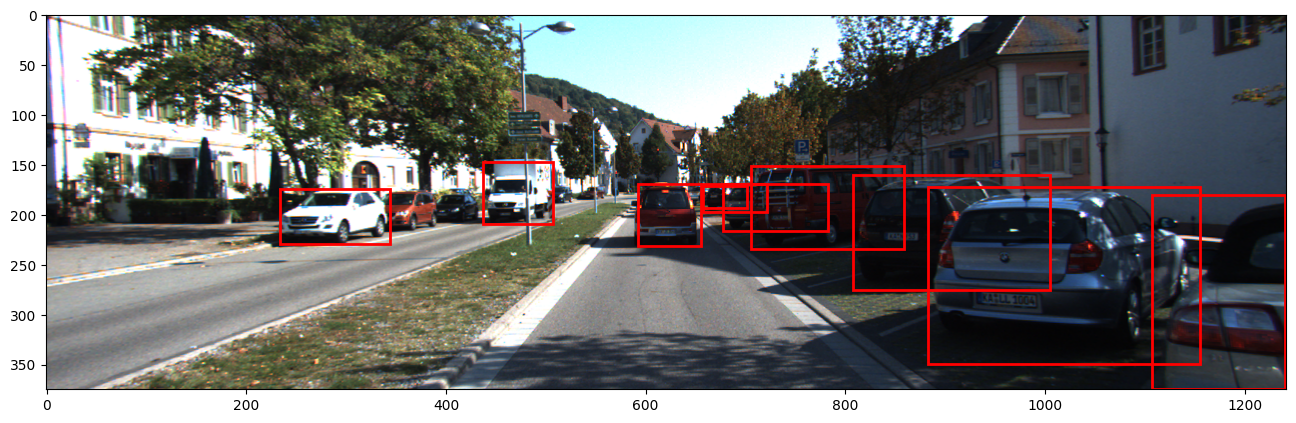

In [54]:
for f in range(165, df[0].max()):
    _, ax = plt.subplots(figsize=(16, 12))
    img = imread(f'data/training/image_02/0011/{f:06}.png')
    plt.imshow(img)
    for _, (x1, y2, x2, y1) in df[(df[0] == f)].iloc[:, 6:10].iterrows():
        ax.add_patch(plt.Rectangle([x1, y1], x2 - x1, y2 - y1,
                     edgecolor='r', facecolor='none', linewidth=2))
        # ax.scatter((x2 + x1) / 2, (y2 + y1) / 2, marker='*', c='r', s=150)
    sleep(0.5)
    clear_output()
    plt.show()
    break

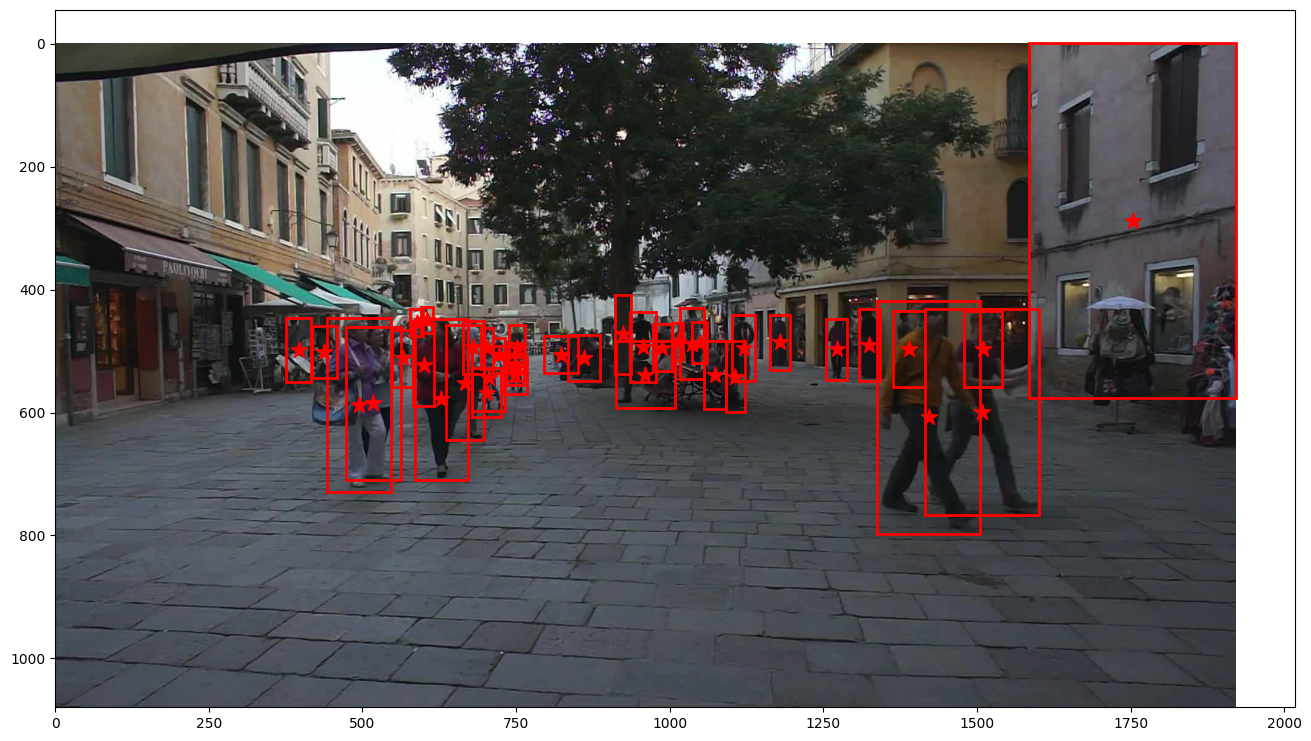

In [4]:
df = pd.read_csv('data/MOT/train/MOT17-02-DPM/gt/gt.txt', header=None)

for f in df[0].unique():
    _, ax = plt.subplots(figsize=(16, 12))
    img = imread(f'data/MOT/train/MOT17-02-DPM/img1/{f:06}.jpg')
    plt.imshow(img)
    for _, (x1, y1, x2, y2) in df[df[0] == f].iloc[:, 2:6].iterrows():
        ax.add_patch(plt.Rectangle([x1, y1], x2, y2,
                     edgecolor='r', facecolor='none', linewidth=2))
        ax.scatter(x1 + x2 / 2, y1 + y2 / 2, marker='*', c='r', s=150)
    sleep(0.5)
    clear_output()
    plt.show()
    break

In [5]:
# occ = Occlusion('data/MOT/train', 'MOT17-07-DPM', occluded_objects=12, occlusion_frames=90, occlusion_type='car', dataset="mot", save_annotations=True)
occ = Occlusion('data/training/', '0011', occluded_objects=8, occlusion_frames=90, occlusion_type='car')
# occ.add_occlusions()
# occ.add_all_bboxes()
# occ.save_mot('data/occ', 'MOT17-02-DPM')
# occ.save_video('test.mp4')

In [6]:
occ.df.iloc[:,2:] += np.random.randn(*occ.df.iloc[:,2:].shape)

In [7]:
occ.df = occ.df.sample(frac=0.9).sort_index()

In [8]:
occ.save_video('test.mp4')